# Reconocimiento de eventos y escenas sonoras  

## Aplicaciones:
* Crimen: disparos, vidrio quebrandose
* Clasificación de archivos multimedia -> Mejores búsquedas
* Detección de contexto: e.g prevención de accidentes automovilísticos
* Clasificación de género musical
* Reconocimiento de que persona está hablando en una conversación
* Speech to text
* Clasificación de emociones

## Ventajas
* El sonido viaja a través de obstáculos a diferencia de la luz.
* Grabar sonido es más económico, en espacio y energía.

## Dificultades
* Caracteríticas acústicas de un evento pueden variar mucho, e.g. gritar
* Hay muchos sonidos de ambiente algunos con características similares al evento en cuestión.
* Distorsión por sonidos del ambiente.
* No existe una taxonomía para sonidos. 

## Definiciones

**Evento sonoro**: Sonido específico producido por una única fuente física. (carro pasando, timbre, pájaro cantando). Usualmente tienen una duración breve y bien definida.

** Escena sonora**: Totalidad de sonidos provenientes de una escena (niños jugando, carros pasando, música, etc.)

## Tareas
### Clasificación
* Casa, calle o oficina
* Disparo, pito, etc.

### Detección de eventos
* Encontrar en el tiempo el acontecimiento de un sonido específico
* Descripción de eventos en terminós textuales abstractos (casa, oficina, calle)
* Hace una decada el foco estaba en la separación de fuentes, reducción de reverberación y estimación de frecuencias fundamentales.

## Anotación de datos
![image](annotations.png)

## A continuación se analizan datos de sonidos urbanos, los cuáles se pueden encontrar en el siguiente enlace: https://datahack.analyticsvidhya.com/contest/practice-problem-urban-sound-classification/

In [62]:
import pandas as pd
from collections import Counter
labels = pd.read_csv('urban_audio_train/train.csv')
{k: v for k, v in Counter(labels['Class']).items()}

{'air_conditioner': 600,
 'car_horn': 306,
 'children_playing': 600,
 'dog_bark': 600,
 'drilling': 600,
 'engine_idling': 624,
 'gun_shot': 230,
 'jackhammer': 668,
 'siren': 607,
 'street_music': 600}

Class:  engine_idling , File: 4327 , Sampling rate: 22050 , Lenght: 88200


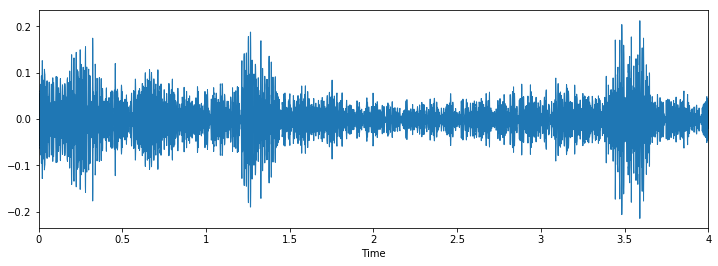

In [72]:
%matplotlib inline
import random
import librosa
from librosa import display
from matplotlib import pyplot as plt
while True:
    try:
        i = random.choice(labels.index)
        audio_name = labels.ID[i]
        path = 'urban_audio_train/Train/' + str(audio_name) + '.wav'        
        x, sr = librosa.load(path)
        print('Class: ', labels.Class[i], ', File:',i,
               ', Sampling rate:',sr, ', Lenght:', len(x))
        plt.figure(figsize=(12, 4))
        display.waveplot(x, sr=sr)
        plt.show()
        import IPython.display as ipd
    except:
        continue
    break
ipd.Audio(path)

## División en ventanas de tiempo 
###   Usualmente se usan ventanas de 30 o 60 ms
###   Las ventanas se sobrelapan en un porcentaje (50%)
###   Se suavizan los bordes utilizando una función de ventana
![image](feature_extraction.png)

In [77]:
%matplotlib inline  
from ipywidgets import interact
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
import numpy as np

output_notebook()

window_size = int(sr * 0.06)
n_windows   = len(x)//window_size


t = np.arange(window_size)/sr
signal_plot = figure(title="Señal en una ventana",
           plot_height=300, plot_width=600)
signal = signal_plot.line(t, x[0:window_size], color="#2222aa", line_width=3)
def update(current_window=0):
    interval = np.arange(int(window_size*current_window), int(window_size*(current_window+1)))
    signal.data_source.data['y'] = x[interval]
    push_notebook()
    
show(signal_plot, notebook_handle=True)
interact(update, current_window =(0, n_windows-1 , 0.5))

Loading BokehJS ...

<function __main__.update>

## Features acústicos
* Zero Crossing rate: Veces que se cruza el cero dividido por el tiempo.
* Energy: suma de cuadrados de los valores de la señal.
* Entropía de la energía: medida de cambios abruptos.
* Centroide espectral: centro de gravedad del espectro.
* Varianza del espectro
* Flujo espectral: la diferencia de cuadrados entre las magnitudes de los espectros de dos marcas de tiempo subsiguientes
* Rolloff espectral: percentil 90 de la distribucion del espectro
* MFCCs: Mel frequency cepstral coefficients. Se divide el espcectro en distintas bandas según la escala de Mel. 
* Vector Chroma: representación en espacios de semitonos. Aplicaciones musicales.
* Desviación Chroma

## Transformada de Fourier
\begin{equation}
S(k) = \sum_{n=1}^N s(n) h(n)\exp (-i\,2\pi n \, k/K), \quad 1\leq k \leq K
\end{equation}

* $K$ es el número total de puntos en la muestra y la frecuencia de muestra es $K/T$. Según el teorema de muestreo de Nyquist-Shannon, la frecuencia máxima discernible es $K/(2T)$. Las frecuencias más altas no se pueden discernir entre si (aliasing).

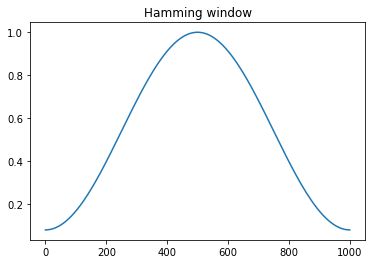

In [26]:
plt.plot(np.hamming(1000))
plt.title('Hamming window')
plt.show()

In [78]:
spec = np.absolute(np.fft.fft(x[0:window_size]))
freq = np.fft.fftfreq(window_size, d = 1/sr)

fft_plot = figure(title="Espectro de la señal en cada ventana",
           plot_height=300, plot_width=600, x_range=(0,freq.max()))
f_transform = fft_plot.line(freq, spec, color="#2222aa", line_width=3)

def update_fft(current_window=0):
    interval = np.arange(int(window_size*current_window), int(window_size*(current_window+1)))
    f_transform.data_source.data['y'] = np.absolute(np.fft.fft(x[interval]))
    push_notebook()
    
show(fft_plot, notebook_handle=True)
interact(update_fft, current_window =(0, n_windows-1 , 1))

<function __main__.update_fft>

## MFCC - Coeficientes cepstrales de frecuencias de Mel
1. Suponemos que la señal de audio cambia poco en intervalos cortos. (Es una serie de tiempo estacionaria).
2. Se calcula el espectro de cada intervalo. (FFT)
3. El oido humano no discierne bien frecuencias próximas, en especial para las frecuencias más altas. Se divide el espectro por bandas y se calcula la energia en cadas una de las bandas. Esto se hace utilizando las bandas de Mel
    * La primera banda es angosta y detecta frecuencias cerca de los 0 Hz
    * Las bandas se agrandan a medida que las freciencias crecen
    * Escala de Mel (convierte la frecuencia a la frecuencia percibida): 
    
    \begin{equation}
    M(f) = 1125 \, \ln(1 + f/700)
    \end{equation}
![image](mel_filter_bank.png)
    
4. Se toma el logaritmo de la energia en cada banda. El oido actua en una escala logaritmica de acuerdo a la potencia del sonido.
5. Se toma la transformada discreta de cosenos (DCT) por dos motivos:
    * Ayuda a quitar la correlación entre los coeficientes debido a que las ventanas se traslapan.
    * Se comprimen los features y se elimina el ruido. 
6. Se puede hacer el mismo análisis pero restando las energías de las frecuencias que aparecen de una ventana a la siguiente. (Esto es importante para aplicaciones como text to speech.)

mfccs shape: (40, 173)


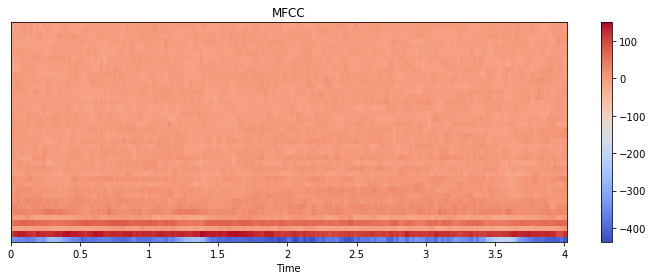

In [75]:
mfccs = librosa.feature.mfcc(y=x, sr=sr, n_mfcc=40, n_fft = window_size)
print('mfccs shape:', mfccs.shape)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfccs, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

In [54]:
import numpy as np
def parser(row):
    file_name = 'urban_audio_train/Train/' + str(row.ID) + '.wav'
   # handle exception to check if there isn't a file which is corrupted
    try:
        
        X, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
        
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T,axis=0) 
    except Exception as e:
        #if file is corrupt return None
        return(None, None)
    feature = mfccs
    label = row.Class
    return [feature, label]

train_data = labels.apply(parser, axis=1)
train_data.columns = ['feature', 'label']
train_data.dropna(inplace=True)

In [55]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV, train_test_split
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}

X = np.array(train_data.feature.tolist())
y = np.array(train_data.label.tolist())

svc = svm.SVC()
clf = GridSearchCV(svc, parameters, n_jobs=4, verbose = 2,
                   refit = True, scoring ='accuracy')
clf.fit(X, y)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] C=1, kernel=linear ..............................................
[CV] C=1, kernel=linear ..............................................
[CV] C=1, kernel=linear ..............................................
[CV] C=1, kernel=rbf .................................................
[CV] .................................. C=1, kernel=rbf, total=   1.0s
[CV] C=1, kernel=rbf .................................................
[CV] .................................. C=1, kernel=rbf, total=   1.0s
[CV] C=1, kernel=rbf .................................................
[CV] .................................. C=1, kernel=rbf, total=   1.0s
[CV] C=10, kernel=linear .............................................
[CV] ............................... C=1, kernel=linear, total= 1.2min
[CV] C=10, kernel=linear .............................................
[CV] ............................... C=1, kernel=linear, total= 1.3min
[CV] C=10, kernel

[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed: 11.9min remaining:    0.0s
[Parallel(n_jobs=4)]: Done  12 out of  12 | elapsed: 11.9min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid={'kernel': ('linear', 'rbf'), 'C': [1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=2)

In [8]:
print('Best score:', clf.best_score_, '. All scores:', clf.cv_results_['mean_test_score'])

Best score: 0.702452316076 . All scores: [ 0.70245232  0.29291553  0.69891008  0.32343324]


In [76]:
pd.DataFrame.from_dict(clf.cv_results_)

/home/carlos/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/carlos/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/carlos/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/home/carlos/anaconda3/lib/python

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_C,param_kernel,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,75.394815,0.062614,0.702452,0.815664,1,linear,"{'C': 1, 'kernel': 'linear'}",1,0.706939,0.811043,0.704490,0.814724,0.695902,0.821224,4.560608,0.000339,0.004730,0.004209
1,0.787430,0.200772,0.292916,0.999591,1,rbf,"{'C': 1, 'kernel': 'rbf'}",4,0.288980,0.999182,0.288163,0.999591,0.301639,1.000000,0.007122,0.001142,0.006165,0.000334
2,616.810047,0.060062,0.698910,0.820025,10,linear,"{'C': 10, 'kernel': 'linear'}",2,0.702857,0.817996,0.694694,0.818814,0.699180,0.823265,34.130779,0.000507,0.003340,0.002315
3,0.802699,0.201369,0.323433,0.999864,10,rbf,"{'C': 10, 'kernel': 'rbf'}",3,0.315102,0.999591,0.322449,1.000000,0.332787,1.000000,0.003578,0.002586,0.007251,0.000193


In [61]:
clf.predict([np.mean(mfccs, axis = 1)])

array(['car_horn'],
      dtype='<U16')

## Predicting multiple classes and detection
![image](detection.png)
